<a href="https://www.kaggle.com/code/chalseo/seattle-pet-license-data-visualization?scriptVersionId=214654643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from urllib.request import urlopen
import json
import requests

In [2]:
import plotly.express as px
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = 'iframe'
pio.templates.default = 'presentation'

# Active/Current Seattle Pet License Registrations

In [3]:
data = pd.read_csv("/kaggle/input/active-seattle-pet-licenses-9-24-2024/Seattle_Pet_Licenses_20240924.csv", index_col="License Number")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43683 entries, S107948 to 8056586
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   License Issue Date  43683 non-null  object 
 1   Animal's Name       43642 non-null  object 
 2   Species             43683 non-null  object 
 3   Primary Breed       43683 non-null  object 
 4   Secondary Breed     29506 non-null  object 
 5   ZIP Code            43558 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.3+ MB


## Data Exploration & Cleaning
* After converting the "Liscense Issue Date' column to datetime format, I am creating a 'Year' column to track registration rates at a higher level for a histogram.
* Only some rows have missing data - Animal's Name, Secondary Breed, and ZIP Code: 
  * For ZIP Code, I will use a null value of 0 to avoid those rows when data processing.
  * For the Animal's Name, and Secondary breeds I used a null value of "Not Specified" to indicate missing data for later steps.


In [4]:
data['License Issue Date'] = pd.to_datetime(data["License Issue Date"], format="%B %d %Y")
data['Year Issued'] = data['License Issue Date'].apply(lambda date: date.year)
data['ZIP Code'] = data['ZIP Code'].fillna(0).astype(int)

data = data.reset_index().drop_duplicates(subset=['License Number'], keep='first')
data = data.fillna("Not Specified")

data.head()

,License Number,License Issue Date,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code,Year Issued
0,S107948,2015-12-18,Zen,Cat,Domestic Longhair,Mix,98117,2015
1,S116503,2016-06-14,Misty,Cat,Siberian,Not Specified,98117,2016
2,S119301,2016-08-04,Lyra,Cat,Mix,Not Specified,98121,2016
3,962273,2019-02-13,Veronica,Cat,Domestic Longhair,Not Specified,98107,2019
4,S133113,2019-08-10,Spider,Cat,LaPerm,Not Specified,98115,2019


## Exploratory Analysis & Data Visualizations
* Seattle law covers animal registrations of: potbelly pig, miniature goat, cat, and dog licenses, guard and attack dog licenses, and exotic animal permits. For the purposes of this dataset, only cats, dpgs, pigs and goats are currently registered with the City of Seattle.
* The bulk of registrations happened post-2022, and this data references the most up to date registrations as of September 24, 2024. 
    * This may be because Seattellites have to renew their registration yearly. So it makes sense most of the registrations are from the most recent year.
    * To renew your registration you have to pay 125 dollars for an an altered pet and 250 dollars for an unaltered pet. If you forget to renew it on time you incur a late fee of up to thirty-five dollars plus a new regisration fee. Renewal fees can range from 15 to 60 dollars depending on the pet.

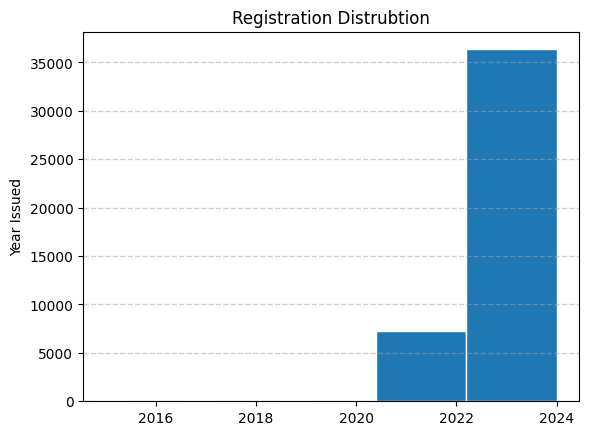

In [5]:
plt.hist(data['Year Issued'], bins=5, edgecolor='white')

plt.title('Registration Distrubtion')
plt.ylabel("Year Issued")

plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.5)
plt.show()

In [6]:
fig = px.histogram(data, x='Year Issued', facet_col='Species', facet_col_wrap=2, height=750,
             nbins=10, text_auto=True, title="Registration by Species")

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', griddash="2px", mirror=True)

fig.update_layout(font=dict(size=12))
fig.show()

In [7]:
breed_count = pd.DataFrame(data.groupby(['Species', "Animal's Name"])["ZIP Code"].count().rename('Count'))
breed_count = breed_count.reset_index(level=[0,1])

print("Goat Names:", breed_count[breed_count.Species == "Goat"]["Animal's Name"].unique())
print("\nPig Names:", breed_count[breed_count.Species == "Pig"]["Animal's Name"].unique())

Goat Names: ['Abelard' 'Bubbles' 'Carmella' 'Darcy' 'Finn' 'Hanna' 'Hardy' 'Mollie'
 'Moppet' 'Negroni' 'Pepina' 'Phyllis' 'Piper' 'Sassy' 'Tacoma' 'Teddy']

Pig Names: ['Calvin' 'Millie' 'Waffles Olivia McHart']


* Names for cats and dogs were very similar for the top five. 80% of the names were the same.
* The frequency of names for goats and pigs were all 1, as there were very few samples of those species to begin with. This makes sense as it much easier to own, afford, and care for cats and dogs.

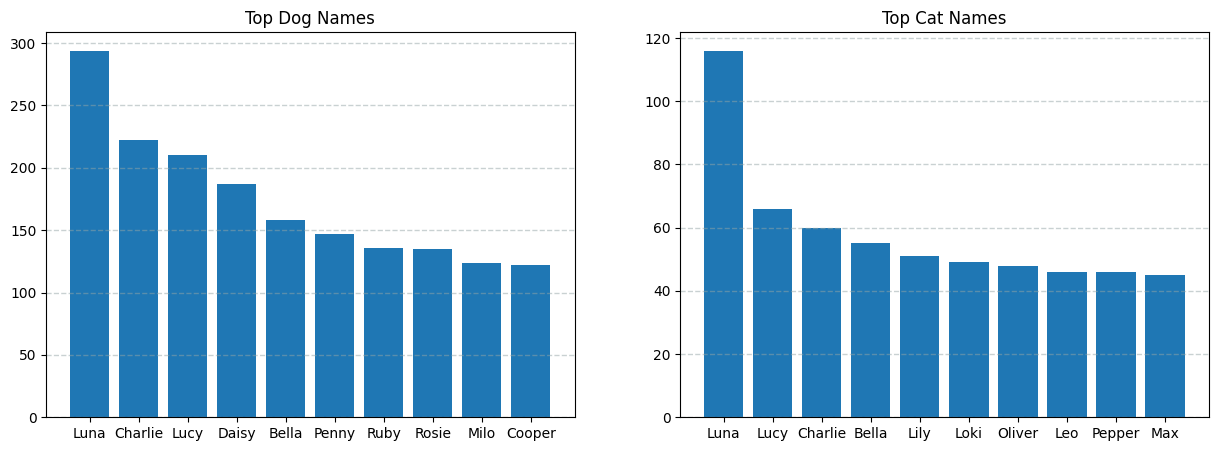

In [8]:
cats = breed_count[breed_count.Species == "Cat"].nlargest(10, "Count").drop(columns=["Species"])
dogs = breed_count[breed_count.Species == "Dog"].nlargest(10, "Count")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.bar(dogs["Animal's Name"], dogs["Count"])
ax1.set_title('Top Dog Names')

ax2.bar(cats["Animal's Name"], cats["Count"])
ax2.set_title('Top Cat Names')

ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.5)
ax2.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.5)

fig.show()

* For breeds, especially, secondary breeds, I expect most would be some variation of mixed breed. So depending on whether we want to focus on dogs reported as one breed, that could give us more precision into what specific pet breeds Seattleites own.
    * The mixed breeds dropped from this visualization were all the most common type of pet registered.

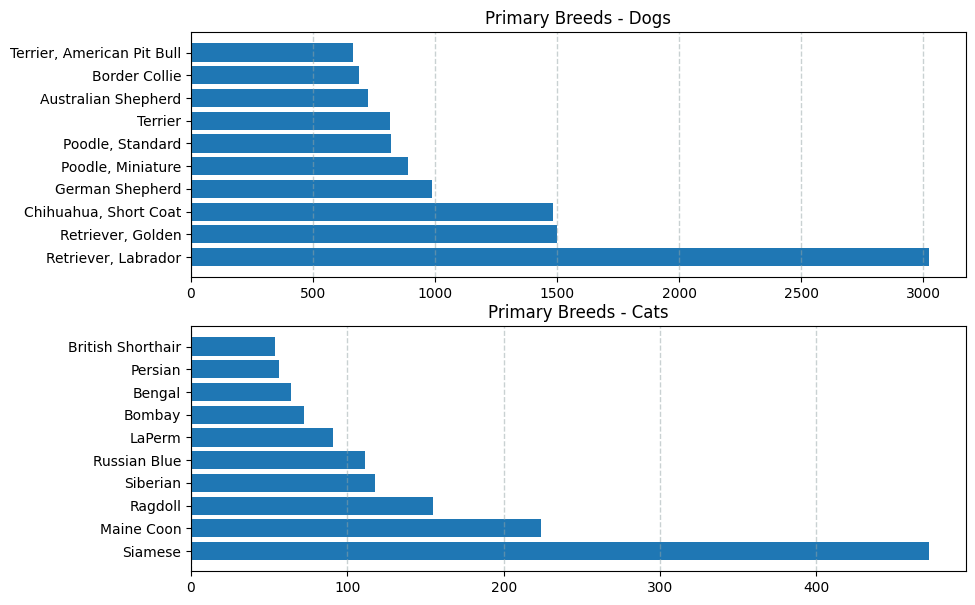

In [9]:
dogs = data[data.Species == "Dog"]["Primary Breed"].value_counts()
for general_type in ["Mixed Breed, Medium (up to 44 lbs fully grown)", "Mixed Breed, Large (over 44 lbs fully grown)"]:
    dogs = dogs.drop(general_type)
dogs = dogs[0:10]
    
cats = data[data.Species == "Cat"]["Primary Breed"].value_counts()
for general_type in ["Mix","Domestic Longhair", "Domestic Medium Hair", "Domestic Shorthair", "American Shorthair"]:
    cats = cats.drop(general_type)
cats = cats = cats[0:10]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
ax1.barh(dogs.index, dogs.values)
ax1.set_title('Primary Breeds - Dogs')

ax2.barh(cats.index, cats.values)
ax2.set_title('Primary Breeds - Cats')

ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='x', alpha=0.5)
ax2.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='x', alpha=0.5)

fig.show()

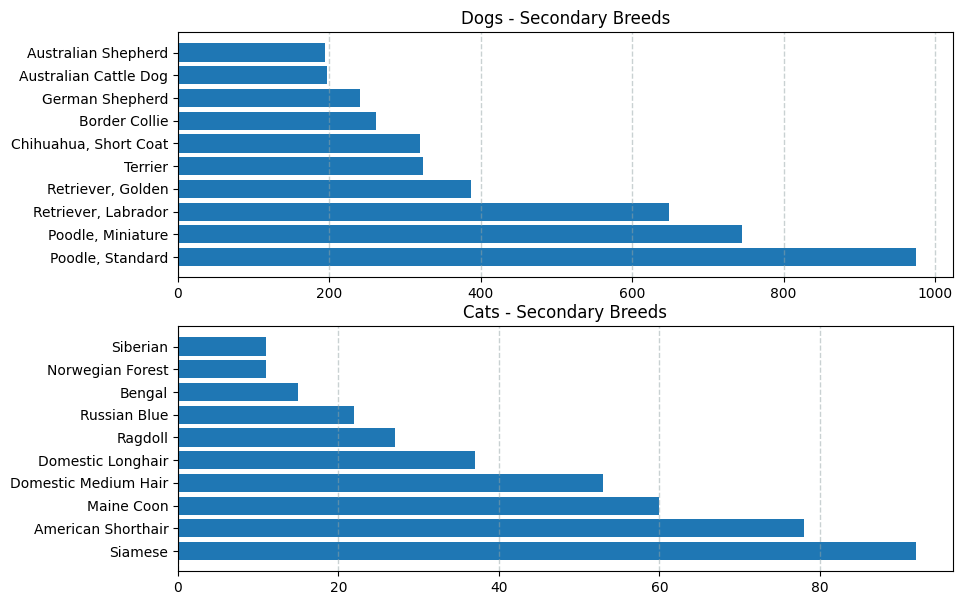

In [10]:
dogs = data[data.Species == "Dog"]["Secondary Breed"].value_counts()
dogs = dogs.drop("Not Specified")
dogs = dogs.drop("Mix")[0:10]

cats = data[data.Species == "Cat"]["Secondary Breed"].value_counts()
cats = cats.drop("Not Specified")
cats = cats.drop("Domestic Shorthair")
cats = cats.drop("Mix")[0:10]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
ax1.barh(dogs.index, dogs.values)
ax1.set_title('Dogs - Secondary Breeds')

ax2.barh(cats.index, cats.values)
ax2.set_title('Cats - Secondary Breeds')

ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='x', alpha=0.5)
ax2.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='x', alpha=0.5)

fig.show()

In [11]:
url = "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/refs/heads/master/data/zip-codes.geojson"
seattle_zips_json = []

with urlopen(url) as response:
    seattle_zips_json = json.load(response)

zip_codes = []
for i in range(len(seattle_zips_json['features'])):
    code = seattle_zips_json['features'][i]['properties']['ZCTA5CE10']
    zip_codes.append(code)

zip_codes = pd.DataFrame({'ZIP Code': zip_codes})
zip_codes['ZIP Code'] = zip_codes['ZIP Code'].astype(int)

zip_codes_count = data.groupby(["ZIP Code"]).count()['Species']
zip_codes_count = zip_codes.merge(zip_codes_count, on="ZIP Code", how="outer").rename({"Species": "ZIP Code Count"}, axis=1).fillna(0.0)

data = data.merge(zip_codes_count, on="ZIP Code")

In [12]:
zip_codes_count_species = data.groupby(["ZIP Code", "Species"]).count()["Primary Breed"].reset_index(level=1).rename(
    columns={"Primary Breed": "ZIP Count", "Species": "ZIP_Species"})

for animal in zip_codes_count_species.ZIP_Species.unique():
    data = data.merge(zip_codes_count_species[zip_codes_count_species.ZIP_Species == animal], on="ZIP Code",
                      how='left').rename({"ZIP Count": "ZIP Code Ratio_"+animal}, axis=1).drop("ZIP_Species", axis=1)
    data["ZIP Code Ratio_"+animal] /= data["ZIP Code Count"]
    data["ZIP Code Ratio_"+animal] = round(data["ZIP Code Ratio_"+animal]*100, 2)

data = data.fillna(0.0)

In [13]:
data = data.merge(data.groupby(["ZIP Code"])["Animal's Name"].agg(pd.Series.mode), 
                  on="ZIP Code").rename({"Animal's Name_y": "ZIP Code Most Freq Name(s)"}, axis=1)
data.head(3) 

,License Number,License Issue Date,Animal's Name_x,Species,Primary Breed,Secondary Breed,ZIP Code,Year Issued,ZIP Code Count,ZIP Code Ratio_Cat,ZIP Code Ratio_Dog,ZIP Code Ratio_Pig,ZIP Code Ratio_Goat,ZIP Code Most Freq Name(s)
0,S107948,2015-12-18,Zen,Cat,Domestic Longhair,Mix,98117,2015,2975.0,29.71,70.22,0.0,0.07,Charlie
1,S116503,2016-06-14,Misty,Cat,Siberian,Not Specified,98117,2016,2975.0,29.71,70.22,0.0,0.07,Charlie
2,S119301,2016-08-04,Lyra,Cat,Mix,Not Specified,98121,2016,793.0,43.76,56.24,0.0,0.00,Bella


In [14]:
fig = px.choropleth(data,
                    geojson= seattle_zips_json,
                    locations='ZIP Code',
                    featureidkey="properties.ZCTA5CE10",
                    color='ZIP Code Count',
                    color_continuous_scale="blues",
                    projection="mercator",
                    title="Seattle Pet Registrations",
                    hover_data=["ZIP Code Count", "ZIP Code Most Freq Name(s)", "ZIP Code Ratio_Cat", "ZIP Code Ratio_Dog", "ZIP Code Ratio_Pig", "ZIP Code Ratio_Goat"],
                    labels={"ZIP Code Count": "Registrations", "ZIP Code Ratio_Cat": "Cat Ratio", "ZIP Code Ratio_Dog": "Dog Ratio", 
                            "ZIP Code Ratio_Pig": "Pig Ratio", "ZIP Code Ratio_Goat": "Goat Ratio"},
                    )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(font=dict(size=12))
fig.show()